# Elasticsearch exploration

Dans ce notebook, nous allons explorer notre index elasticsearch crée par la stack **training-app** de la config *docker-compose*

In [3]:
from search.utils import Elasticsearch
from elasticsearch_dsl import Search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# figure size in inches
plt.rcParams['figure.figsize'] = 15,10
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":18,"axes.labelsize":14}) 

In [4]:
es = Elasticsearch(timeout=15)
es.indices.get_alias("*")

{'.monitoring-es-6-2019.05.27': {'aliases': {}},
 'tmdb_preprocessed': {'aliases': {}},
 '.monitoring-es-6-2019.05.28': {'aliases': {}},
 'tmdb': {'aliases': {}},
 '.monitoring-es-6-2019.05.29': {'aliases': {}}}

In [5]:
count_all_query = {
    "query": {
        "match_all": {}
    }
}
es.count(index="tmdb", body=count_all_query)

{'count': 27846,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}

### Premier moyen de read en scrollant (pas très performant au final)

In [6]:
# response = es.search(
#     index='tmdb',
#     scroll='10m'
# )
# df_elastic = pd.DataFrame()
# while len(response['hits']['hits']):
#     # transformer les json en colonnes pandas
#     df_elastic = df.append(pd.io.json.json_normalize(response['hits']['hits']))
#     response = es.scroll(scroll_id=response['_scroll_id'], scroll='10m')

## Deuxième moyen de read beaucoup plus rapide via du scan

In [7]:
# s= Search(using=es,index="tmdb")
# df_elastic = pd.DataFrame((d.to_dict() for d in s.scan()))

## Troisième et dernier moyen trouvé via du multi-threading et l'API Sliced Scroll d'Elasticsearch

In [13]:
from multiprocessing import Pool
import time
import json

SLICES = 5                                                                      


def dump_slice(slice_no):                                                       
    s = Search(using=es, index="tmdb")                                                               
    s = s.extra(slice={"id": slice_no, "max": SLICES})                          
    return pd.DataFrame((d.to_dict() for d in s.scan()))


while True:
    try:
        pool = Pool(SLICES)                                                          
        results = pool.map(dump_slice, range(SLICES))
        df_elastic = pd.concat(results)
    except (json.decoder.JSONDecodeError, elasticsearch.TransportError):
        time.sleep(5)
        continue
    break    

In [14]:
df_elastic.reset_index(inplace=True, drop=True)

In [15]:
df_elastic.shape

(27846, 31)

In [16]:
df_elastic.columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'cast',
       'directors', 'genres', 'homepage', 'id', 'imdb_id', 'mlensId',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'status_code', 'status_message', 'tagline', 'title', 'title_sent',
       'video', 'vote_average', 'vote_count'],
      dtype='object')

In [17]:
clean_columns = ["budget", "revenue", "title", "original_language", "popularity", "overview", "release_date",
                "tagline", "vote_average", "vote_count", "id"]
dirty_columns = ["cast", "directors", "genres"]

In [18]:
df_elastic[dirty_columns].head()

,cast,directors,genres
0,"[{'order': 0, 'id': 9235, 'cast_id': 7, 'credi...","[{'id': 4818, 'department': 'Directing', 'cred...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
1,"[{'order': 0, 'id': 3894, 'cast_id': 35, 'cred...","[{'id': 525, 'department': 'Directing', 'credi...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name..."
2,"[{'order': 0, 'id': 380, 'cast_id': 16, 'credi...","[{'id': 1032, 'department': 'Directing', 'cred...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name..."
3,"[{'cast_id': 0, 'character': 'The Doctor', 'cr...","[{'credit_id': '57081106c3a3681d240000d7', 'de...","[{'id': 878, 'name': 'Science Fiction'}, {'id'..."
4,"[{'order': 0, 'id': 1003, 'cast_id': 12, 'cred...","[{'id': 59, 'department': 'Directing', 'credit...","[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n..."


## Drop de 187 lignes avec des informations nulles telles que le titre, acteurs, synopsis, etc...

In [19]:
df_elastic.dropna(subset=dirty_columns+clean_columns,inplace=True)
df_elastic.reset_index(inplace=True, drop=True)

## Flattening des dirty columns, en effet le format JSON est utile pour du relationnel SQL mais dans notre cas d'exploration nope

In [20]:
df_elastic[dirty_columns] = df_elastic[dirty_columns].applymap(lambda x: "|".join([str(json_nested["name"]) for json_nested in x]))

# KPI computing

## Dans l'optique qu'un film serait un freelance, plusieurs questions business peuvent être posées.

Ainsi la partie du notebook ci-dessous va calculer quelques KPI non exhaustives dont j'ai pu penser lors de l'analyse de l'index en question. Plusieurs optiques sont envisagées pour définir ce qu'est un freelance pour répondre à différentes questions en utilisant la donnée la plus logique pour y répondre.

### **Movie == Freelance AND Genres == Technologies**

1. Quelles sont **les technologies les plus populaires** auprès des freelances ?
2. Quelle est la distribution de l'inscription des freelance au cours des années depuis la création de la plateforme ?
3. Quelle est la repartion des TJM **(budget)** des freelances sur la plateforme ? A mettre en relation avec l'ancienneté du freelance **(release_date)** et la popularité des technologies utilisées par le freelance.
4. Le freelance a-t-il bien soigné son profil en décrivant bien les missions effectuées **length(overview)** ?

Pour la question 3 et 4, on peut envisager un plan d'action de contact par mail du freelance s'il fait parti des mauvais élèves dans le remplissage de son profil et son TJM par rapport au reste de la communauté.

### **Movie == Mission AND Cast (acteurs) == Freelance**
En effet si un movie est un freelance, le problème est que c'est une clé unique, or notre freelance peut apparaître plusieurs fois puisqu'il effectue différentes missions. Cette optique nous permet de répondre à plus de questions sous un nouvel angle.
Le seul souci de cette approche est qu'un movie a plusieurs acteurs, du coup dans ce cas une mission aura plusieurs freelances dessus. Cela peut-être résolu en prenant seulement le premier acteur. Mais ici pour garder de la donnée complète, nous garderons cette multiplicité des freelances par mission.

5. Quels sont les freelances **(cast)** qui rapportent le plus d'argent **(revenue)** lors de toutes leurs missions effectuées sur la plateforme Comet ?
6. Combien de temps un freelance attend-t-il en moyenne avant de retrouver une mission sur la plateforme ?
7. Les missions effectuées sont-elles plutôt longues ou courtes **(runtime)** ? Y'a-t-il eu un changement au cours des années dans les durées des missions ? 

[Lien trouvé pour m'inspirer sur quelques questions à poser](https://github.com/deepak525/Investigate_TMDb_Movies/blob/master/investigate_the_TBMb_Dataset.ipynb)

In [42]:
df = df_elastic.copy()

In [45]:
df.columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'cast',
       'directors', 'genres', 'homepage', 'id', 'imdb_id', 'mlensId',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'status_code', 'status_message', 'tagline', 'title', 'title_sent',
       'video', 'vote_average', 'vote_count'],
      dtype='object')

## **Question 1. Quelles sont les technologies les plus populaires auprès des freelances ?**

In [22]:
df["genres"] = df["genres"].str.split("|", n=100, expand=False) 
counts = pd.Series(np.concatenate(df.genres)).value_counts()

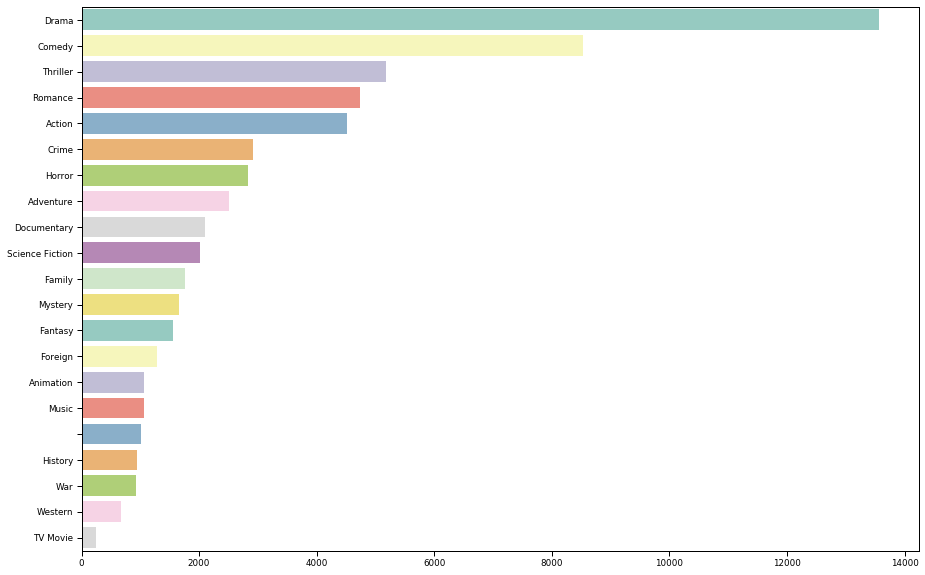

In [23]:
sns.barplot(x=counts.values, y=counts.index, palette="Set3")

Cela peut nous donner une indication de quelle type de mission il faudra aller chercher auprès des clients.

On verra qu'en envisageant les **movies comme des missions**, on pourra même **clusteriser les technologies** pour voir quels sont les combos de technologies demandé par mission, ainsi plutôt que d'avoir une vue techno par techno on aura une vue groupe de technos demandées par mission

## **Question 2. Quelle est la distribution de l'inscription des freelance au cours des années depuis la création de la plateforme ?**

In [24]:
df["year"] = pd.DatetimeIndex(df['release_date']).year

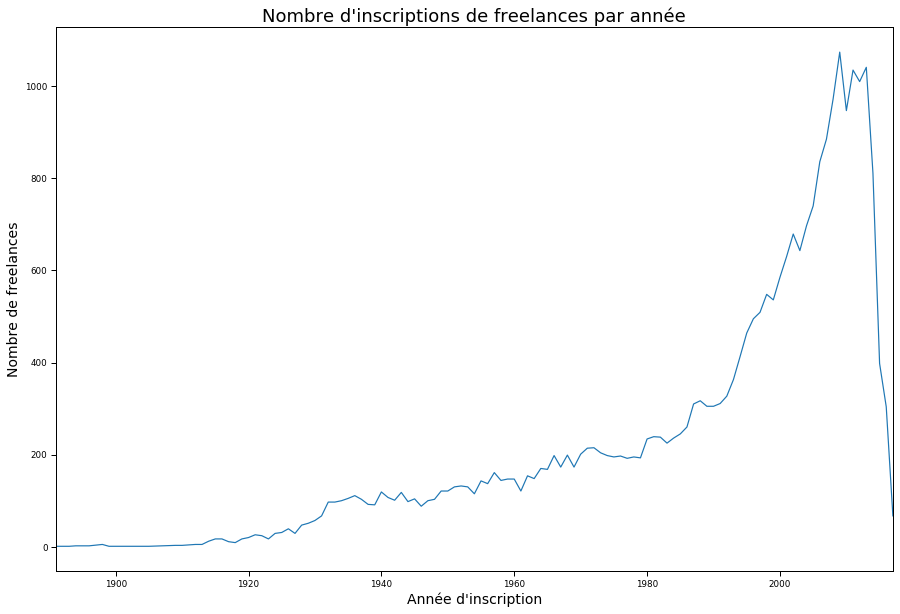

In [25]:
df.groupby('year').count()['id'].plot(y=plt.ylabel("Nombre de freelances"),
                                      title="Nombre d'inscriptions de freelances par année")
_ = plt.xlabel("Année d'inscription")

Cela nous donne une indication de la croissance de la plateforme pour les inscriptions, on pourra également corréler ceci avec une **analyse des messages Slack.** Par exemple savoir si nos freelances restent actifs malgré une diminution des inscriptions sur un mois

## **Question 3.** Quelle est la repartion des TJM **(budget)** des freelances sur la plateforme ? A mettre en relation avec l'ancienneté du freelance **(release_date)** et la popularité des technologies utilisées par le freelance.

In [26]:
top10_techno = counts.nlargest(10)

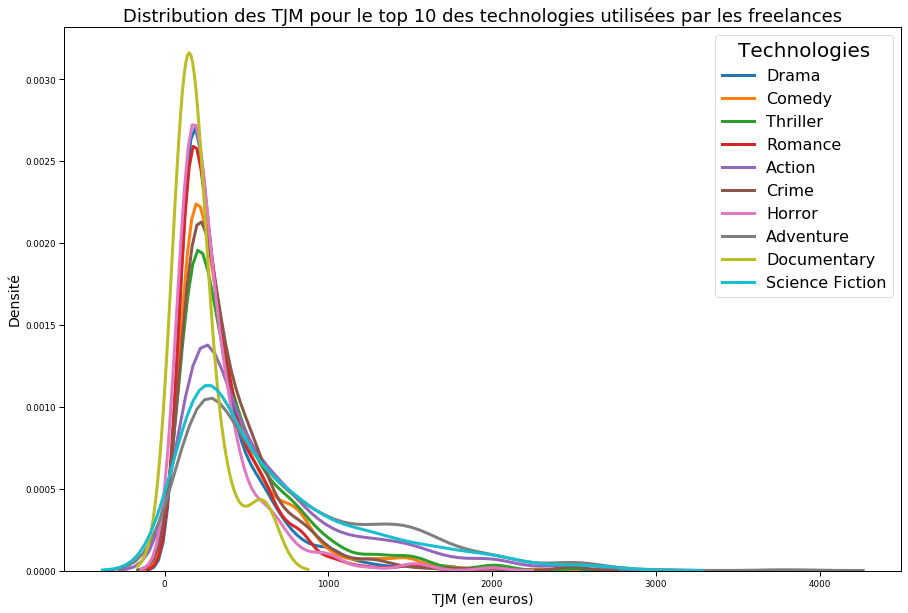

In [27]:
for techno in top10_techno.index:
    df_modified = df[df.budget > 10000000]
    mask = df_modified.genres.apply(lambda x: techno in x)
    subset = df_modified[mask]

    # Draw the density plot
    sns.distplot(subset['budget']/100000, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = techno)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Technologies')
plt.title('Distribution des TJM pour le top 10 des technologies utilisées par les freelances')
plt.xlabel('TJM (en euros)')
_ = plt.ylabel('Densité')

## **Question 4.** Le freelance a-t-il bien soigné son profil en décrivant bien les missions effectuées **length(overview)** ?
Le raisonnement derrière cette question est de proposer aux freelances (n'ayant pas bien rempli leur profil par leurs missions précédemment effectuées avant Comet), par mail par exemple, d'ajouter des expériences. Ou de demander si par mail si son profil a bien été complété, ce qui lui donnera plus de visibilité.

Pour représenter le nombre de missions et de champs remplis sur son profil, j'utilise la longueur du synopsis du film. On aurait tout à fait pu choisir une autre approche tout aussi valable

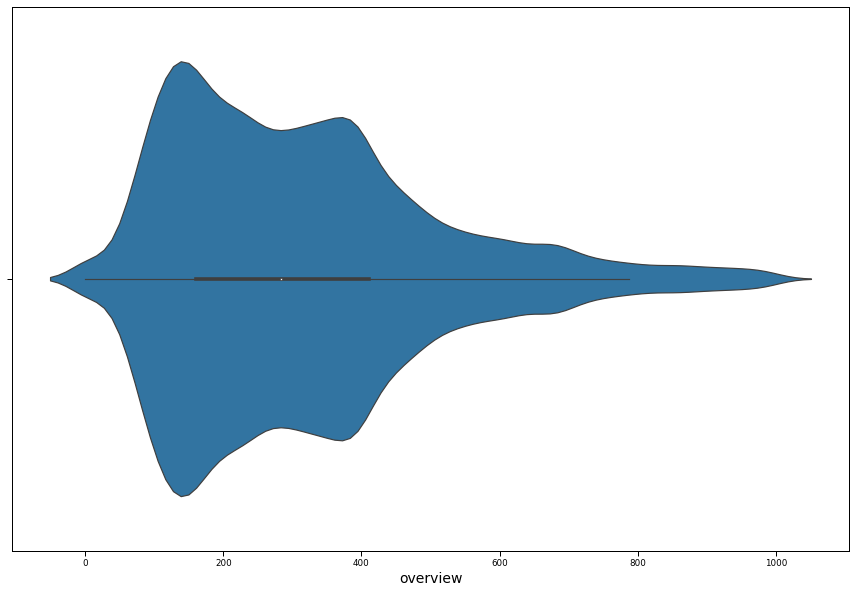

In [28]:
sns.violinplot(df["overview"].str.len())

Cela nous donne une idée sur le nombre de missions effectuées par les freelancers mais également quels sont les freelancers avec un profil quasiment vide, qu'il faut donc relancer pour qu'ils reçoivent des offres pertinentes à l'avenir.

Peut-être à mettre plus en valeur avec le rajout d'une catégorie **Graduated, Junior, Middle et Senior** via **release_date** pour obtenir un graphe plus pertinent.

## **Question 5.** Quels sont les freelances **(cast)** qui rapportent le plus d'argent **(revenue)** lors de toutes leurs missions effectuées sur la plateforme Comet ?

Le raisonnement serait peut-être de mettre en évidence ces profils aux freelances similaires pour qu'ils obtiennent plus de visibilités en améliorant leurs profils.

Là encore à splitter par job, expérience pour pouvoir mieux identifier par type de job / expérience quels sont les profils à recommander pour s'améliorer : comme les technos recherchées / qui rapportent, etc...

In [29]:
df["cast"] = df["cast"].str.split("|", n=100, expand=False) 
# cast_counts = pd.Series(np.concatenate(df.cast, df.revenue)).value_counts()

In [62]:
new_df = df[["cast", "revenue"]]

In [63]:
df_melted = pd.DataFrame({
    col:np.repeat(new_df[col].values, new_df["cast"].str.len())
    for col in new_df.columns.drop("cast")}).assign(**{"cast":np.concatenate(new_df["cast"].values)})

In [64]:
df_grouped = df_melted.groupby("cast").sum()

In [65]:
top10_revenue = pd.Series(index=df_grouped.index, data=df_grouped.revenue.values).nlargest(10)

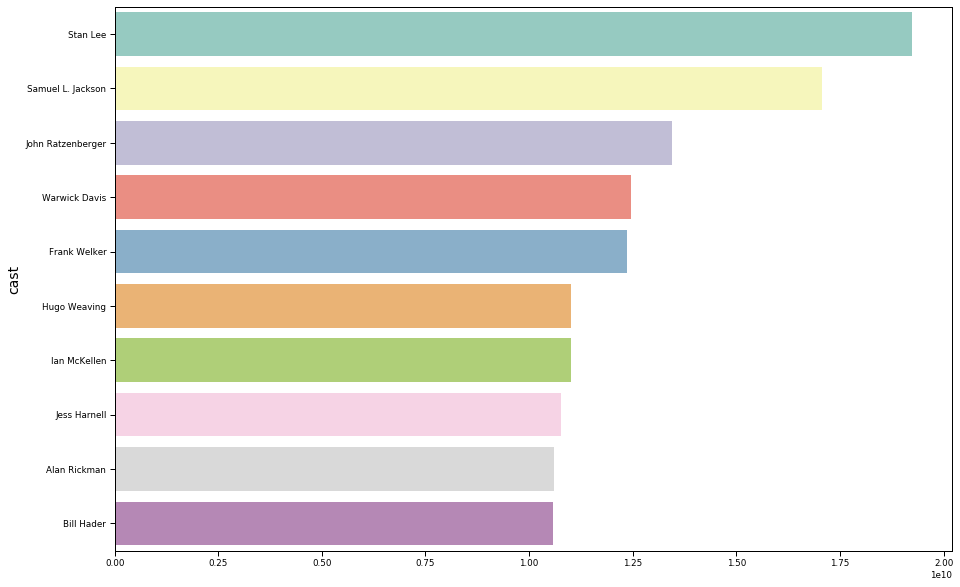

In [66]:
sns.barplot(x=top10_revenue.values, y=top10_revenue.index, palette="Set3")

## **Question 6.** Combien de temps un freelance attend-t-il en moyenne avant de retrouver une mission sur la plateforme ?
Un indicateur pour montrer aux freelances, le temps de battement moyen entre deux missions par exemple. Ou même en interne, cela reste une KPI intéressante pour analyser le marché des missions et de leur enchaînement par profil.

In [128]:
new_df = df[["cast", "release_date"]]
df_melted = pd.DataFrame({
    col:np.repeat(new_df[col].values, new_df["cast"].str.len())
    for col in new_df.columns.drop("cast")}).assign(**{"cast":np.concatenate(new_df["cast"].values)})
# Convert to datetime date_release
df_melted["release_date"] = pd.DatetimeIndex(df_melted['release_date'])
# Drop empty cast
df_melted = df_melted[df_melted.cast != ""]
df_melted["keep_date"] = df_melted["release_date"]
df_melted = df_melted.sort_values(["cast", "keep_date"])

In [130]:
df_melted['date_diff'] = (
    df_melted
       .pop('release_date')
       .groupby(df_melted['cast'])
       .diff()
       .dt.days
       .fillna(0, downcast='infer'))

In [131]:
df_melted.head(20)

,cast,keep_date,date_diff
145823,\tDouglas Hegdahl,1999-06-11,0
283792,\tRobert Osth,1980-03-28,0
284710,\tYip Chun,1994-10-13,0
278122,\tYip Chun,2007-10-01,4736
137607,Alistair Freeland,2005-11-03,0
137606,Belen Blanco,2005-11-03,0
180443,Bill Bunten,2007-03-12,0
369931,Blandine Bury,2005-04-13,0
338038,Dippanita Sharma,2011-12-09,0
264749,Eduard Xatruch,2011-09-15,0


Pour chaque acteur / freelance, on obtient ainsi le temps qu'il met pour travailler sur un nouveau film / mission. Cela nous donne ainsi un indicateur d'enchaînement des missions.

En l'occurence 389 jours sur la totalité de la donnée TMDB

In [134]:
df_melted.groupby("cast").date_diff.mean().mean()

388.96531058991786

## **Question 7.** Les missions effectuées sont-elles plutôt longues ou courtes **(runtime)** ? Y'a-t-il eu un changement au cours des années dans les durées des missions ? 

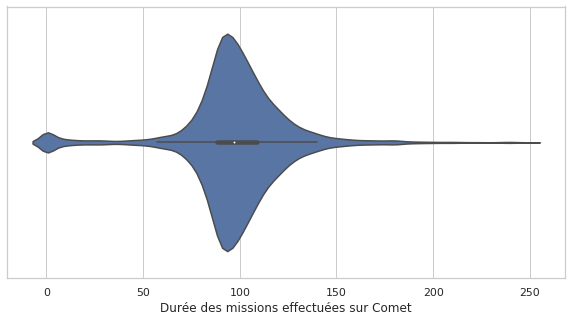

In [148]:
sns.violinplot(df[df["runtime"] < 250].runtime,
               title="Distribution des durées des missions sur Comet")
_ = plt.xlabel("Durée des missions effectuées sur Comet")

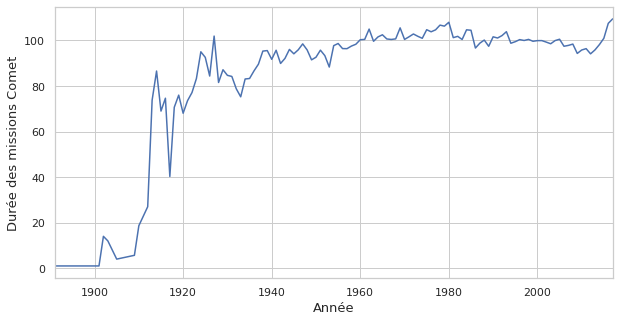

In [150]:
df["year"] = pd.DatetimeIndex(df['release_date']).year
df.groupby('year').mean()['runtime'].plot(y=plt.ylabel('Durée des missions Comet',fontsize = 13))
_ = plt.xlabel('Année',fontsize = 13)